In [2]:
import matplotlib.pyplot as plt
from typing import Literal

E, A, B = 1.69, 406.4, 410.7
alpha, beta = .34, .28

# #epoch values 
# E, A, B = 1.8172, 482.01, 2085.43
# alpha, beta = .3478, .3658
G = (alpha * A/(beta * B)) ** (1/(alpha + beta))


a_K, b_K = .73, .27
a_C, b_C =  .46, .54

# epoch estimates 
# a_C, b_C = .512,(1-.512)


In [3]:
def chinchilla_loss(N, D, irr_loss = False):
    return (0 if not irr_loss else E) + A/(N ** alpha) + B/(D ** beta)

def N_opt(C, paper = Literal['kaplan', 'chinchila']):
    if (paper == 'kaplan'):
        return 9e-7 * C**a_K
    elif paper == 'chinchilla':
        return G * (C/6) ** a_C

def D_opt(C, paper = Literal['kaplan', 'chinchila']):
    if (paper == 'kaplan'):
        return 1/(6 * 9e-7) * C**b_K
    elif paper == 'chinchilla':
        return (1/G) * (C/6) ** b_C


def chinchilla_optimal(C):
    return chinchilla_loss(N_opt(C, 'chinchilla'), D_opt(C, 'chinchilla')) 



def kaplan_optimal(C):
    return chinchilla_loss(N_opt(C, 'kaplan'), D_opt(C, 'kaplan')) 

In [4]:
Cs = [10 ** i for i in range(15, 30)]

[N_opt(C, 'kaplan') * D_opt(C, 'kaplan') * 6/C for C in Cs]
# [N_opt(C, 'chinchilla') * D_opt(C, 'chinchilla') * 6/C for C in Cs]

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0000000000000002,
 1.0,
 1.0000000000000002]

[5.3488528056778755, 3.7578268820475396, 2.6401458405173046, 1.8549579093092188, 1.3033323026148529, 0.9157800556875879, 0.6434904235661976, 0.45217634888355207, 0.31775208316348125, 0.22329743762838278, 0.15692560134130557, 0.11028553422330067, 0.07751003739572494, 0.05447684453745]


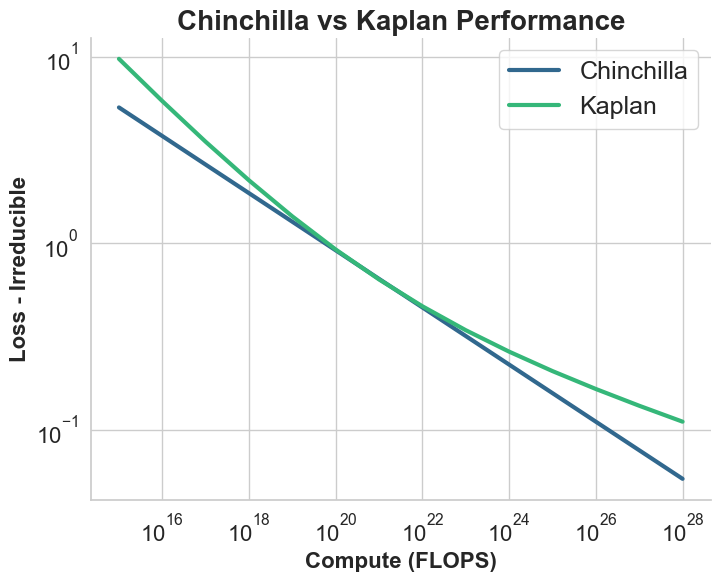

In [8]:
import seaborn as sns

sns.set(style="whitegrid", palette="viridis")
Cs = [10 ** i for i in range(15, 29)]
loss_chinchilla = list(map(chinchilla_optimal, Cs))
loss_kaplan = list(map(kaplan_optimal, Cs))

palette = sns.color_palette("viridis", 2)
plt.figure(figsize=(8, 6))
plt.plot(Cs, loss_chinchilla, label='Chinchilla', color=palette[0], linewidth=3)
plt.plot(Cs, loss_kaplan, label='Kaplan', color=palette[1], linewidth=3)
print(loss_chinchilla)
plt.yscale('log')
plt.xscale('log')
plt.title('Chinchilla vs Kaplan Performance', fontsize=20, fontweight='bold')
plt.xlabel('Compute (FLOPS)', fontsize=16, fontweight='bold')
plt.ylabel('Loss - Irreducible', fontsize=16, fontweight='bold')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=18)
sns.despine()

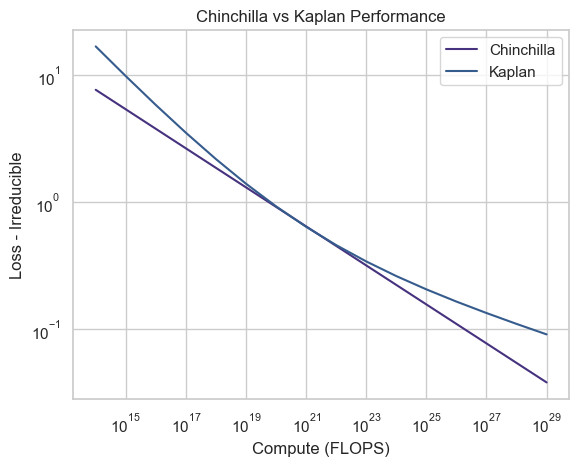

In [6]:
Cs = [10 ** i for i in range(14, 30)]
loss_chinchilla = list(map(chinchilla_optimal, Cs))
loss_kaplan = list(map(kaplan_optimal, Cs))

plt.figure()
plt.plot(Cs, loss_chinchilla, label='Chinchilla')
plt.plot(Cs, loss_kaplan, label='Kaplan')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Compute (FLOPS)')
plt.ylabel('Loss - Irreducible')
plt.title('Chinchilla vs Kaplan Performance')
plt.legend()

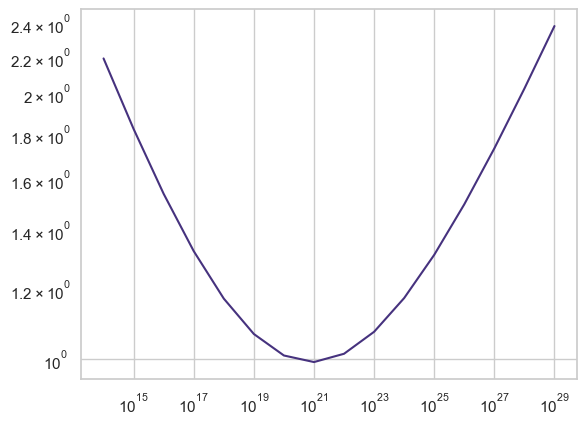

In [7]:
plt.plot(Cs, list(map(lambda s: kaplan_optimal(s) / chinchilla_optimal(s), Cs)), label = 'Kaplan')
plt.yscale('log')
plt.xscale('log')

Compute multiplier range: 0.95x to 2.22x
At C=1e18: Kaplan needs 2.22x more compute
At C=1e24: Kaplan needs 1.82x more compute


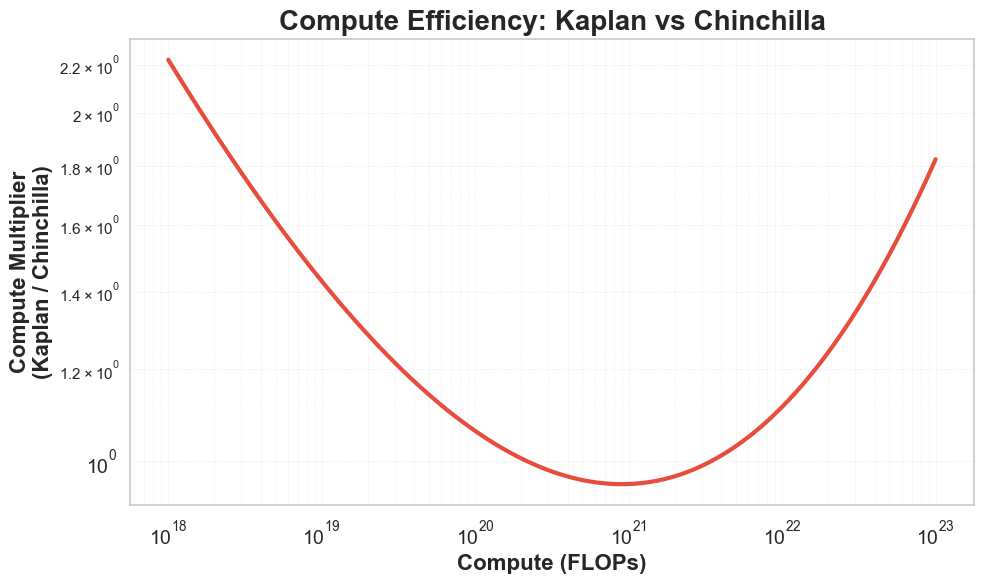

In [11]:
# Compute multiplier: For each loss achieved by Chinchilla at compute C_chinchilla,
# find the compute C_kaplan that Kaplan needs to achieve the same loss.
# Multiplier = C_kaplan / C_chinchilla

import numpy as np
from scipy.optimize import fsolve

# Range of compute values for Chinchilla
Cs_chinchilla = np.logspace(18, 23, 100)

# For each compute level, calculate Chinchilla's loss
losses_chinchilla = [chinchilla_optimal(C) for C in Cs_chinchilla]

# For each loss, find the compute that Kaplan needs to achieve it
compute_multipliers = []
Cs_kaplan_equivalent = []

for i, (C_chinchilla, target_loss) in enumerate(zip(Cs_chinchilla, losses_chinchilla)):
    # Define equation: kaplan_optimal(C) - target_loss = 0
    def equation(C):
        return kaplan_optimal(C) - target_loss
    
    # Initial guess: start from C_chinchilla
    try:
        C_kaplan = fsolve(equation, C_chinchilla)[0]
        if C_kaplan > 0:  # Valid solution
            multiplier = C_kaplan / C_chinchilla
            compute_multipliers.append(multiplier)
            Cs_kaplan_equivalent.append(C_kaplan)
        else:
            compute_multipliers.append(np.nan)
            Cs_kaplan_equivalent.append(np.nan)
    except:
        compute_multipliers.append(np.nan)
        Cs_kaplan_equivalent.append(np.nan)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(Cs_chinchilla, compute_multipliers, linewidth=3, color='#e74c3c')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Compute (FLOPs)', fontsize=16, fontweight='bold')
plt.ylabel('Compute Multiplier\n(Kaplan / Chinchilla)', fontsize=16, fontweight='bold')
plt.title('Compute Efficiency: Kaplan vs Chinchilla', fontsize=20, fontweight='bold')
plt.grid(True, which="both", linestyle=":", linewidth=0.5, alpha=0.6)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

# Print some key values
print(f"Compute multiplier range: {np.nanmin(compute_multipliers):.2f}x to {np.nanmax(compute_multipliers):.2f}x")
print(f"At C=1e18: Kaplan needs {compute_multipliers[np.argmin(np.abs(np.log10(Cs_chinchilla) - 18))]:.2f}x more compute")
print(f"At C=1e24: Kaplan needs {compute_multipliers[np.argmin(np.abs(np.log10(Cs_chinchilla) - 24))]:.2f}x more compute")

plt.savefig('Figures/kaplan_chinchilla_compute_multiplier.png', dpi=200, bbox_inches='tight')
plt.show()


In [10]:
import numpy as np
import math
math.log(1.5,10)/math.log(2, 10)

0.5849625007211563